In [3]:
import warnings

warnings.filterwarnings("ignore")

# Modeling Approach 

## Set Up

Import Libraries 

In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
from pyproj import CRS

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap


from scipy.spatial import distance_matrix
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import rasterio.features
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from scipy.spatial.distance import cdist
from affine import Affine
from scipy.ndimage import gaussian_filter
from rasterio import features 

import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import Affine
from rasterio.features import dataset_features
from scipy import ndimage
from shapely.geometry import Point
import matplotlib.pyplot as plt

Colors

In [94]:
color_palettes = {
    "Mint": ["#EAF4E8", "#C8E0D4", "#A9CCC1", "#8FB9AE", "#76A79D", "#5F968E", "#498581"], 
    "Pi": ["#F8EDEB", "#FAE1DD", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E", "#F08080"],
    "Or": ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"],
    "GrSc":  ['#EFEFEF', '#D9D9D9', '#CCCCCC', '#B7B7B7', '#999999', '#666666', '#434343'],
    "MintPi": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E"],
    "MintOr": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FFD7BA", "#FEC89A", "#FFB78F", "#F28B6D"],
    "MiPiOr": ['#EAF4E8', '#FAE1DD', '#C8E0D4', '#FFD7BA', '#F8EDEB', '#FCD5CE', '#FFE5D9']
}

In [95]:
cmap_mint = LinearSegmentedColormap.from_list("Mint", color_palettes["Mint"])
cmap_pi = LinearSegmentedColormap.from_list("Pi", color_palettes["Pi"])
cmap_or = LinearSegmentedColormap.from_list("Or", color_palettes["Or"])
cmap_mintpi = LinearSegmentedColormap.from_list("MintPi", color_palettes["MintPi"])
cmap_mintor = LinearSegmentedColormap.from_list("MintOr", color_palettes["MintOr"])
cmap_grsc = LinearSegmentedColormap.from_list("GrSc", color_palettes["GrSc"])
cmap_mipior = LinearSegmentedColormap.from_list("MiPiOr", color_palettes["MiPiOr"])

Font

In [96]:
plt.rcParams["font.family"] = "Helvetica"

Berlin Spatial Boundaries

In [97]:
pf = r"../inputs/4.3_modeling_approach/lor_pgr.gpkg"
pgr = gpd.read_file(pf)
pgr.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

bf = r"../inputs/4.3_modeling_approach/adm_bz.gpkg"
bz = gpd.read_file(bf)
bz.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

of = r"../inputs/4.3_modeling_approach/adm_out.gpkg"
out = gpd.read_file(of)
out.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

Data Import

In [98]:
ef = r"../inputs/4.3_modeling_approach/pbsa_capacity_analysis.gpkg"
pbsa_cap = gpd.read_file(ef, driver="GPKG")

hf = r"../inputs/4.3_modeling_approach/uni_int_demand_analysis.gpkg"
uni_dem = gpd.read_file(hf, driver="GPKG")

hf = r"../inputs/4.3_modeling_approach/market_area_central_place_analysis_35_min.gpkg"
market_area = gpd.read_file(hf)

pf = r"../inputs/4.3_modeling_approach/central_places.gpkg"
central_places = gpd.read_file(pf)

/Users/natashlaz/Applications/anaconda3/envs/geodatascience2.0/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(
/Users/natashlaz/Applications/anaconda3/envs/geodatascience2.0/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


skip? since i already have central place analysis 

## Gravitational Analysis

Origins and Destinations

In [241]:
x_orig = pbsa_cap.geometry.x.values
y_orig = pbsa_cap.geometry.y.values
orig_grid = np.column_stack([x_orig, y_orig])   # shape (N,2)

# Market centres → destinations (column axis)
x_dest = central_places.geometry.x.values
y_dest = central_places.geometry.y.values
dest_grid = np.column_stack([x_dest, y_dest]) 

Distance Matrix

In [242]:
dist_mat = cdist(orig_grid, dest_grid)

In [243]:
print(dist_mat)

[[ 9148.01073778 13720.08780758  5687.10799293 ... 11823.10663779
   9782.82893533  1563.85184819]
 [11658.10260416 20552.4649919  11355.85376215 ... 13463.88815785
  15400.95841063  8997.28132231]
 [ 5142.28861368  5894.72019861 14436.89187149 ...  6473.04028034
    274.33517207  8172.8356834 ]
 ...
 [ 8172.87893737 17862.71869981 12225.28950626 ...  9823.90078395
  12436.24193828  7653.87057211]
 [ 5263.51252178 14753.99104784 11698.97754412 ...  7319.29508198
   9297.09494669  5700.21481796]
 [ 8780.79799432  4395.36847063 12666.23094329 ... 10552.00012324
   3933.41749963  8022.83524741]]


Rasterisation Buffer Test 

In [244]:
nearest_to_cp = np.nanmin(dist_mat, axis=1)   # shape (N,)

# distribution stats
stats = {
    'min': float(np.nanmin(nearest_to_cp)),
    '5th_pct': float(np.nanpercentile(nearest_to_cp, 5)),
    '25th_pct': float(np.nanpercentile(nearest_to_cp, 25)),
    'median': float(np.nanpercentile(nearest_to_cp, 50)),
    '75th_pct': float(np.nanpercentile(nearest_to_cp, 75)),
    '90th_pct': float(np.nanpercentile(nearest_to_cp, 90)),
    'max': float(np.nanmax(nearest_to_cp))
}
stats


{'min': 262.5854342308858,
 '5th_pct': 320.0675464225281,
 '25th_pct': 923.7070168600136,
 'median': 2210.3560826400685,
 '75th_pct': 3511.584659094876,
 '90th_pct': 4847.007501263491,
 'max': 7285.6787494876}

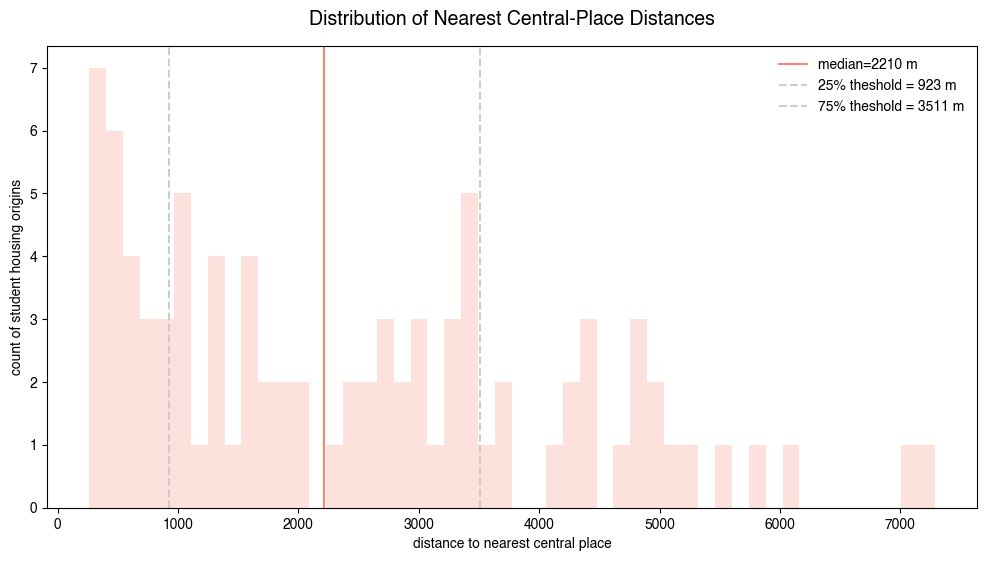

In [245]:
plt.figure(figsize=(12,6))

plt.hist(nearest_to_cp, bins=50, color='#FCD5CE', alpha=0.7, density=False)
plt.xlabel('distance to nearest central place')
plt.ylabel('count of student housing origins')
plt.title('Distribution of Nearest Central-Place Distances', fontsize=14, pad=15, fontweight='bold')

plt.axvline(stats['median'], color="#F28B6D", label=f"median={int(stats['median'])} m")
plt.axvline(stats['25th_pct'], color='#cccccc', linestyle='--', label=f"25% theshold = {int(stats['25th_pct'])} m")

plt.axvline(stats['75th_pct'], color='#cccccc', linestyle='--', label=f"75% theshold = {int(stats['75th_pct'])} m")

plt.legend(frameon=False)
plt.show()

*Figure XX. bla bla bla*

Beta Test

β < 1 – the model is weakly distance‑decaying; potentials stay large and are influenced by many distant demand points.  

β around 1–1.5 – a good balance: close points still dominate, but there is some “spill‑over”.       

β > 1.5 – as you saw, potentials shrink rapidly.    

β ≥ 2 the values tend to zero unless you have an exact hit (distance ≈ 0).  

In [246]:
betas = np.arange(0.5, 3.5, 0.25)  

results = {}

attract = central_places["!s_aus"].values

pot_dict = {}

for beta in betas:
    safe_dist = np.where(dist_mat == 0, 1e-6, dist_mat)   # avoid division by 0
    weights   = attract / (safe_dist ** beta)             # (N,M)

    # SUM over demand points → (N,)
    pot = weights.sum(axis=1) * pbsa_cap["!cap"].values   # <-- 1‑D

    pot_col = f"potential_beta_{beta}"
    pot_dict[pot_col] = pot

    print(f"β = {beta:>4.2f} | mean = {pot.mean():>8.2f} | std = {pot.std():>8.2f}")

for cname, data in pot_dict.items():
    pbsa_cap[cname] = data

β = 0.50 | mean =   695.23 | std =   805.00
β = 0.75 | mean =    94.39 | std =   135.08
β = 1.00 | mean =    14.18 | std =    24.96
β = 1.25 | mean =     2.36 | std =     4.96
β = 1.50 | mean =     0.43 | std =     1.03
β = 1.75 | mean =     0.08 | std =     0.22
β = 2.00 | mean =     0.02 | std =     0.05
β = 2.25 | mean =     0.00 | std =     0.01
β = 2.50 | mean =     0.00 | std =     0.00
β = 2.75 | mean =     0.00 | std =     0.00
β = 3.00 | mean =     0.00 | std =     0.00
β = 3.25 | mean =     0.00 | std =     0.00


Attractiveness, Gravitational Weights and Potential 

In [247]:
beta = 1.25

# attractiveness column 
attract = central_places["!s_aus"].values   # shape (M,)

# Avoid division by zero – the PBSA may never coincide with a centre
eps = 1e-6 
dist_cache = np.where(dist_mat == 0, eps, dist_mat)   # tiny value instead of 0

weights = (attract / (dist_cache**beta)) 

potential = weights.sum(axis=1)              # shape (N,)

# Add the potential back to the PBSA GeoDataFrame
pbsa_cap["!cap"] = potential

Buffering Geometry

Medium / neighbourhood buffer: 500–1500 m (typical: 1 000 m)

Rationale: 10–15 minute walk / 5–10 minute bike — a reasonable “neighbourhood” catchment for students choosing housing. For most PBSA, nearest central-place distances around the median will fall into this range.

Use for modeling local market influence and accessibility to universities / transit hubs.

In [248]:
buffer = stats['25th_pct']    

pbsa_buffer = pbsa_cap.geometry.buffer(buffer)

central_places_buffer = central_places.geometry.buffer(buffer)

Raster Parameters Definition: Extent, Resolution and Affine Transform

In [249]:
resolution = 25          # metres per pixel (very fine!)
sigma      = 0.25          # Gaussian‑smoothing width 

# Assume market_area is already loaded (or replace with your own GeoDataFrame)
minx, miny, maxx, maxy = market_area.total_bounds

# Affine transform that maps pixel numbers to world coordinates
transform = Affine.translation(minx, maxy) * Affine.scale(resolution, -resolution)

# Image size
width  = int(np.ceil((maxx - minx) / resolution))
height = int(np.ceil((maxy - miny) / resolution))

Potential and Attractiveness Rasterisation 

In [250]:
potential_vals = zip(pbsa_buffer, pbsa_cap["!cap"])

potential_raster = features.rasterize(
    potential_vals,
    out_shape=(height, width),
    fill=np.nan,                     # No value outside the buffers
    transform=transform,
    dtype=np.float32,
    all_touched=True                 # fill every pixel that the polygon touches
)

attract_vals = zip(central_places_buffer, central_places["!s_aus"])

attract_raster = features.rasterize(
    attract_vals,
    out_shape=(height, width),   # same shape as the potential raster
    fill=np.nan,                 # no value outside central‑place polygons
    transform=transform,
    dtype=np.float32,
    all_touched=True,            # gives every pixel that the point touches
)

Gaussian Smoothing

In [251]:
smooth_potential_raster = gaussian_filter(potential_raster, sigma=sigma, mode='nearest')
smooth_attract_raster = gaussian_filter(attract_raster, sigma=sigma, mode='nearest')

Data Export 

In [252]:
out_raw = r'../outputs/4.3_modeling_approach/potential_raw.tif'
out_smooth = r'../outputs/4.3_modeling_approach/potential_smooth.tif'

out_raw_attr     = r'../outputs/4.3_modeling_approach/attract_raw.tif'
out_smooth_attr  = r'../outputs/4.3_modeling_approach/attract_smooth.tif'

Visualisation

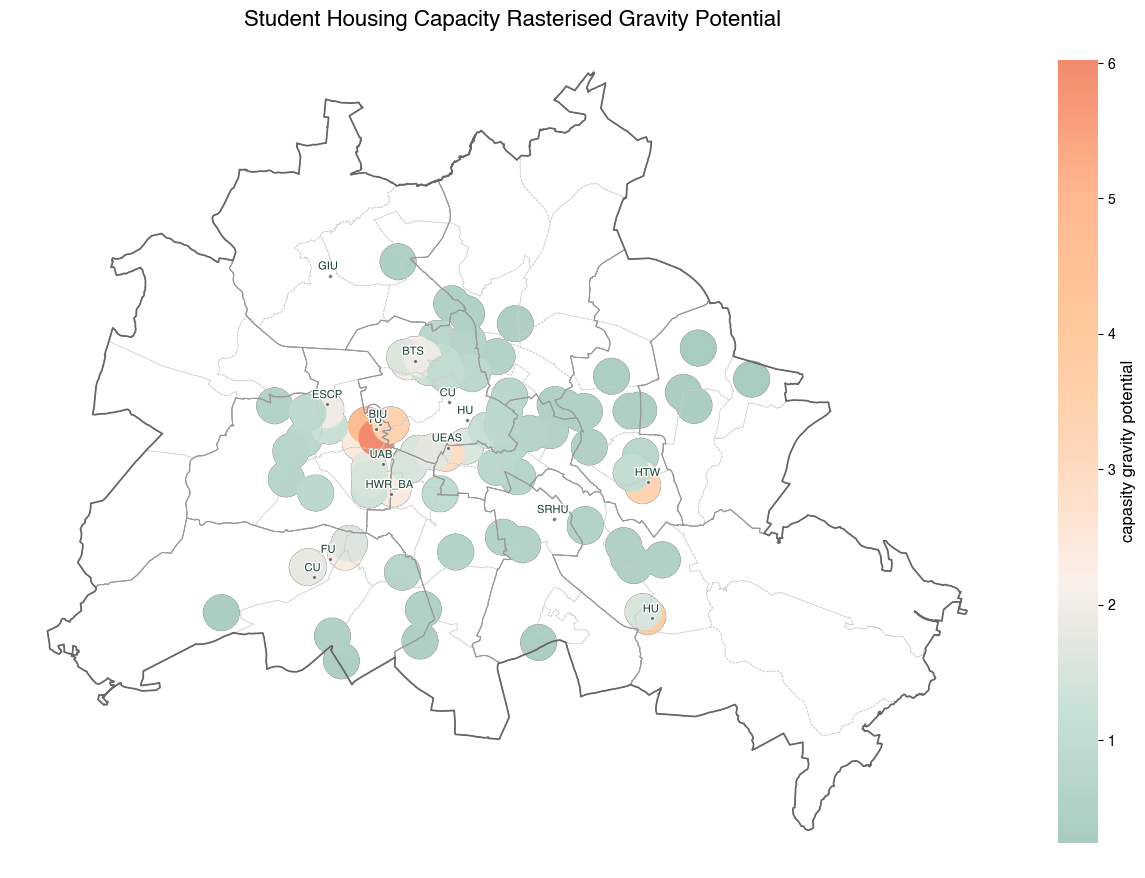

In [253]:
cmap_mintor_mini = ListedColormap(cmap_mintor(np.linspace(0.25, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

cax = ax.imshow(smooth_potential_raster, cmap=cmap_mintor_mini,
                    extent=(minx, maxx, miny, maxy))


cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('capasity gravity potential', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

ax.set_title('Student Housing Capacity Rasterised Gravity Potential', fontsize=16, weight='bold')
ax.set_axis_off()
plt.show()

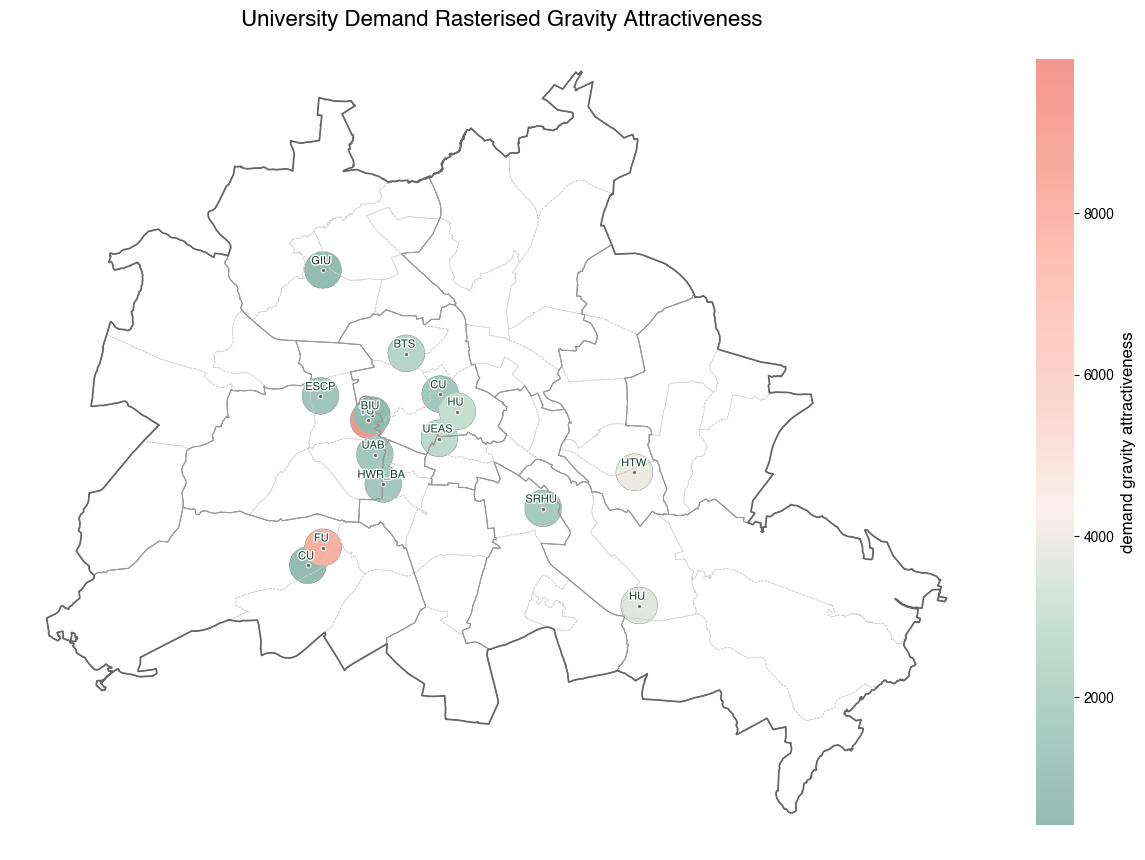

In [254]:
cmap_mintpi_mini = ListedColormap(cmap_mintpi(np.linspace(0.15, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

cax = ax.imshow(attract_raster, cmap=cmap_mintpi_mini,
                    extent=(minx, maxx, miny, maxy))


cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('demand gravity attractiveness', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

ax.set_title('University Demand Rasterised Gravity Attractiveness', fontsize=16, weight='bold')
ax.set_axis_off()
plt.show()

## Potential Gradient Analysis

Gradient of Gravity Potential ?     
Gravity Potential Modeling ?

In [255]:
# First, make sure NaNs are filled to avoid propagation
smooth = np.nan_to_num(smooth_potential_raster, nan=0.0)

# Compute pixel gradients
gy, gx = np.gradient(smooth, edge_order=2)  # gy = ∂/∂y, gx = ∂/∂x

# Convert pixel gradients to real-world (meters)
gx_m = gx / resolution
gy_m = gy / resolution

# Gradient magnitude (rate of change) and direction (angle in radians)
grad_mag = np.sqrt(gx_m**2 + gy_m**2)
grad_dir = np.arctan2(gy_m, gx_m)

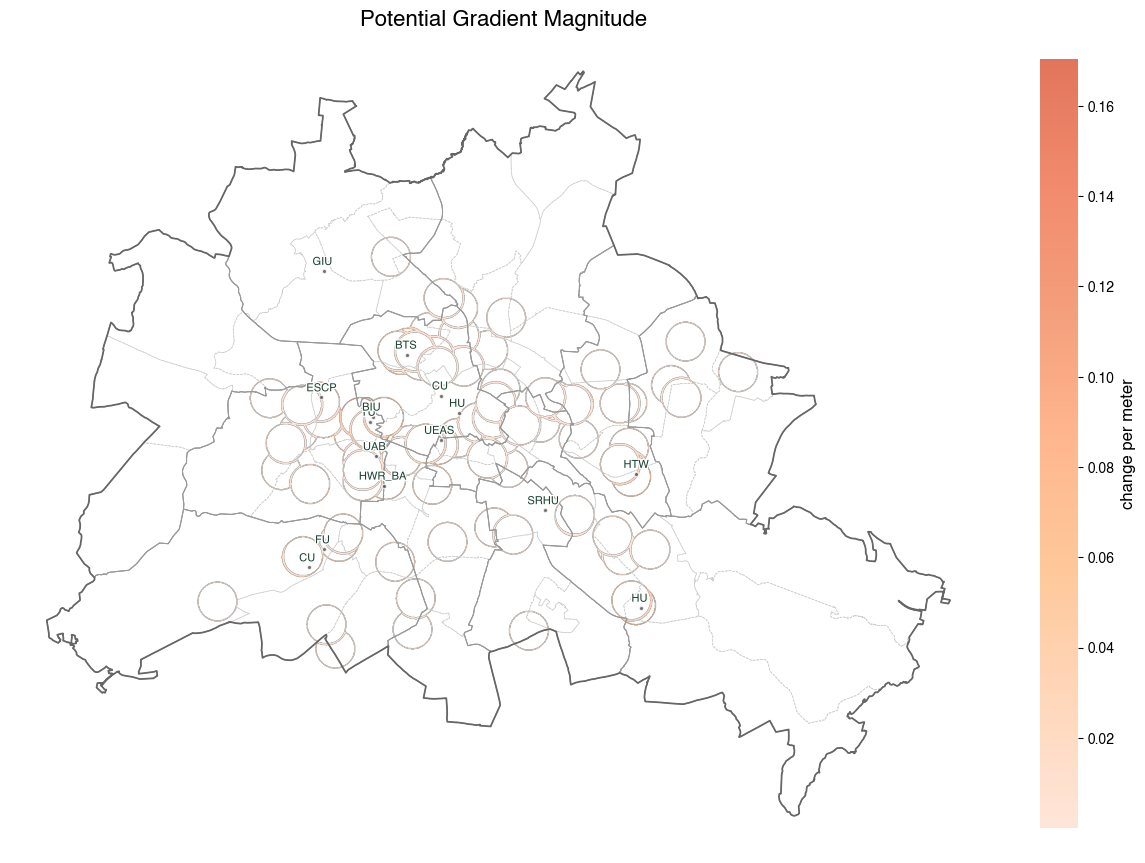

In [256]:
cmap_mintor_mini = ListedColormap(cmap_mintor(np.linspace(0.35, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

# grad_mag_clear = np.where(grad_mag == 0, np.nan, grad_mag) 

cax = ax.imshow(grad_mag_clear , cmap=cmap_or,
                    extent=(minx, maxx, miny, maxy))


cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('change per meter', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

ax.set_title('Potential Gradient Magnitude', fontsize=16, weight='bold')
ax.set_axis_off()
plt.show()

*Figure XX. bla bla bla*

TODO: make it nice

Interpretation:

Bright zones = where potential changes steeply (transition zones or “boundaries” between high/low potential).

Flat zones = where potential is uniform (no strong directional pull).

Gradient Direction Vectorisation 

In [257]:
# Coarse sampling so the map is readable
step = 25  # every Nth pixel

rows = np.arange(0, grad_mag.shape[0], step)
cols = np.arange(0, grad_mag.shape[1], step)

xs, ys, u, v, c = [], [], [], [], []

for r in rows:
    for c_ in cols:
        val = grad_mag[r, c_]
        if np.isnan(val) or val == 0:
            continue
        # pixel → map coordinates
        x, y = rasterio.transform.xy(transform, r, c_, offset='center')
        xs.append(x)
        ys.append(y)
        u.append(gx_m[r, c_])
        v.append(-gy_m[r, c_])  # minus to match north-up
        c.append(val)           # store color value per arrow

# Convert lists to arrays
xs = np.array(xs)
ys = np.array(ys)
u = np.array(u)
v = np.array(v)
c = np.array(c)

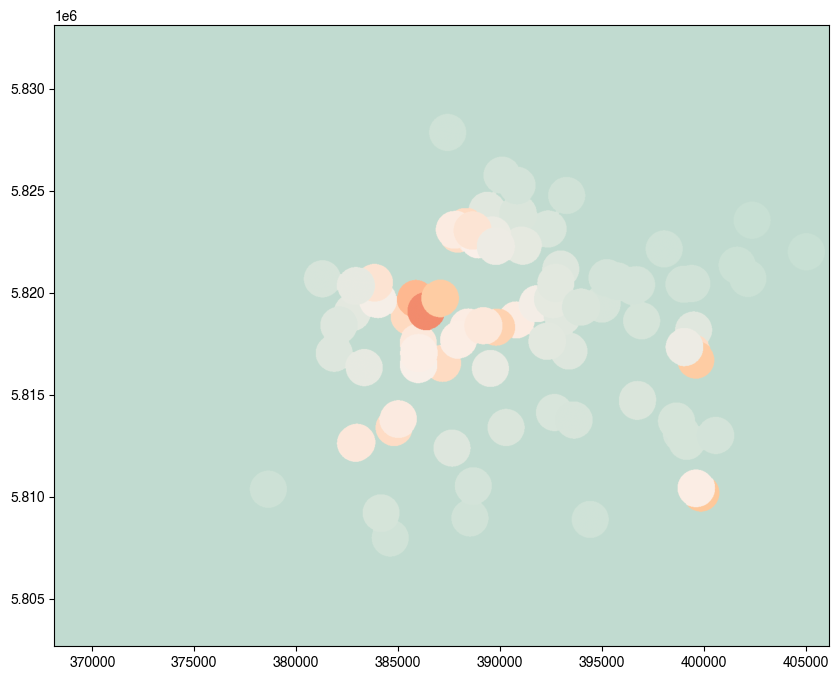

In [263]:
plt.figure(figsize=(10, 10)) 

plt.imshow( smooth, origin='upper', cmap=cmap_mintor_mini, extent=[ transform.c, transform.c + grad_mag.shape[1] * transform.a, transform.f + grad_mag.shape[0] * transform.e, transform.f ] )

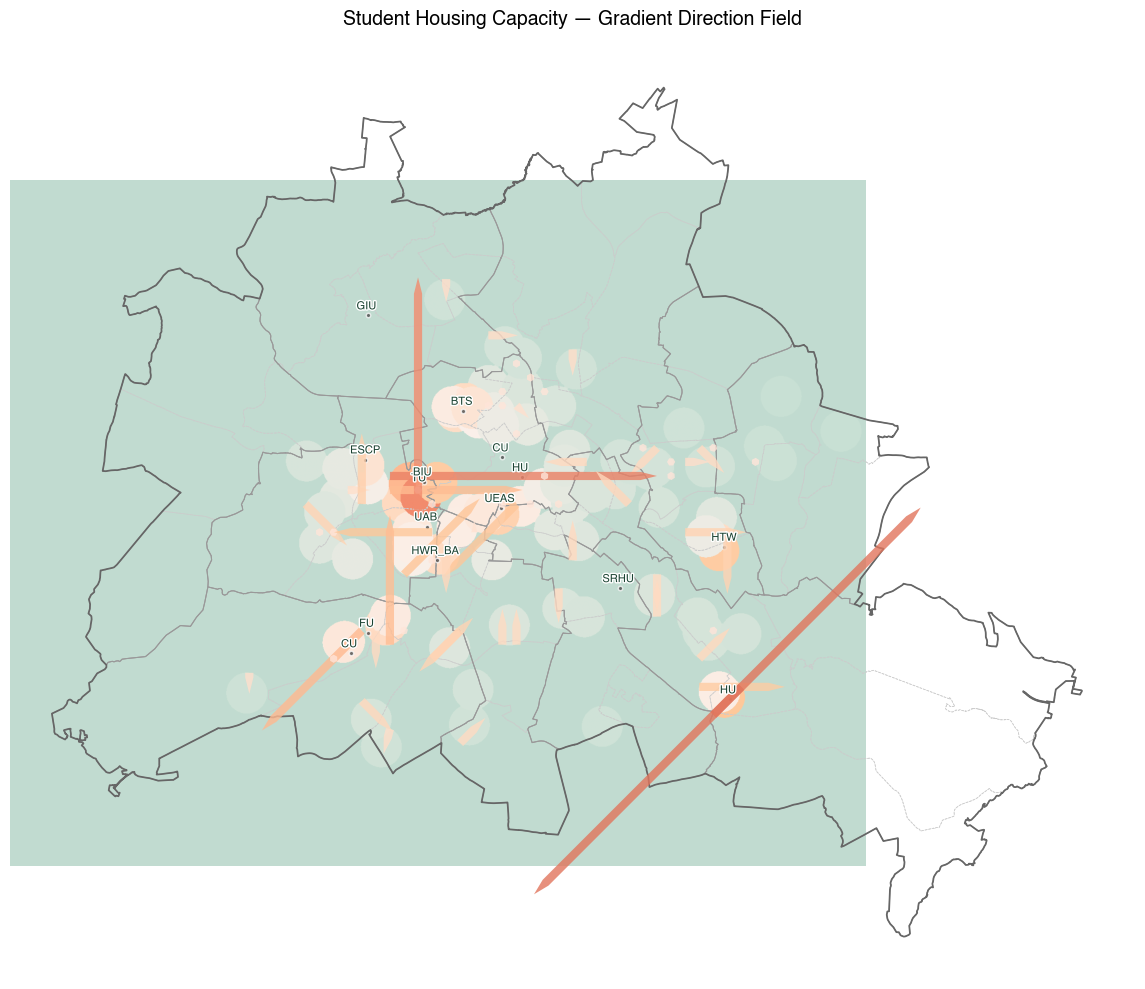

In [265]:
fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

# grad_mag_clear = np.where(grad_mag == 0, np.nan, grad_mag) 

cax = ax.imshow(
        smooth, 
        origin='upper', 
        cmap=cmap_mintor_mini,
        extent=[
        transform.c,
        transform.c + grad_mag.shape[1] * transform.a,
        transform.f + grad_mag.shape[0] * transform.e,
        transform.f
    ])


# cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
# cbar.set_label('change per meter', fontsize=12)
# cbar.outline.set_visible(False)  # cleaner look

plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

#Use per-arrow colors (matching lengths) 
plt.quiver( xs, ys, u, v, c, 
            cmap=cmap_or, 
            scale=0.4, 
            alpha=0.8, 
            linewidth=0.05, 
            headwidth=1,            # smaller arrowheads
            headlength=2, 
            headaxislength=2)

plt.title("Student Housing Capacity — Gradient Direction Field", fontsize=14, pad=15, fontweight='bold')
plt.axis('off')
plt.show()



# plt.figure(figsize=(12, 12))

# pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
# bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
# out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

# plt.imshow(
#     smooth,
#     origin='upper',
#     cmap=cmap_mintor_mini,
#     extent=[
#         transform.c,
#         transform.c + grad_mag.shape[1] * transform.a,
#         transform.f + grad_mag.shape[0] * transform.e,
#         transform.f
#     ]
# )

# # Use per-arrow colors (matching lengths) 
# plt.quiver( xs, ys, u, v, c, 
#            cmap=cmap_or, 
#            scale=0.4, 
#            alpha=0.8, 
#            linewidth=0.05, 
#            headwidth=1,            # smaller arrowheads
#            headlength=2, 
#            headaxislength=2)
           

# plt.title("Student Housing Capacity — Gradient Direction Field", fontsize=14)
# plt.axis('off')
# plt.show()


*Figure XX. bla bla bla*

In [260]:
import numpy as np 
import rasterio 
import matplotlib.pyplot as plt 
# Coarse sampling so the map is readable 
step = 25 # every Nth pixel 
rows = np.arange(0, grad_mag.shape[0], step) 
cols = np.arange(0, grad_mag.shape[1], step) 

xs, ys, u, v, c = [], [], [], [], [] for r in rows: for c_ in cols: val = grad_mag[r, c_] if np.isnan(val) or val == 0: continue 

# pixel → map coordinates 
x, y = rasterio.transform.xy(transform, r, c_, offset='center') xs.append(x) ys.append(y) u.append(gx_m[r, c_]) v.append(-gy_m[r, c_]) # minus to match north-up c.append(val) # store color value per arrow # Convert lists to arrays xs = np.array(xs) ys = np.array(ys) u = np.array(u) v = np.array(v) c = np.array(c) # Plot plt.figure(figsize=(10, 10)) plt.imshow( smooth, origin='upper', cmap=cmap_mintpi_mini, extent=[ transform.c, transform.c + grad_mag.shape[1] * transform.a, transform.f + grad_mag.shape[0] * transform.e, transform.f ] ) # Use per-arrow colors (matching lengths) plt.quiver( xs, ys, u, v, c, # same length as xs, ys, u, v cmap=cmap_pi, scale=0.2, alpha=0.8, linewidth=0.1 ) plt.title("Student Housing Capacity — Gradient Direction Field", fontsize=14) plt.axis('off') plt.show() adjust arrow size

SyntaxError: invalid syntax (1964938052.py, line 9)

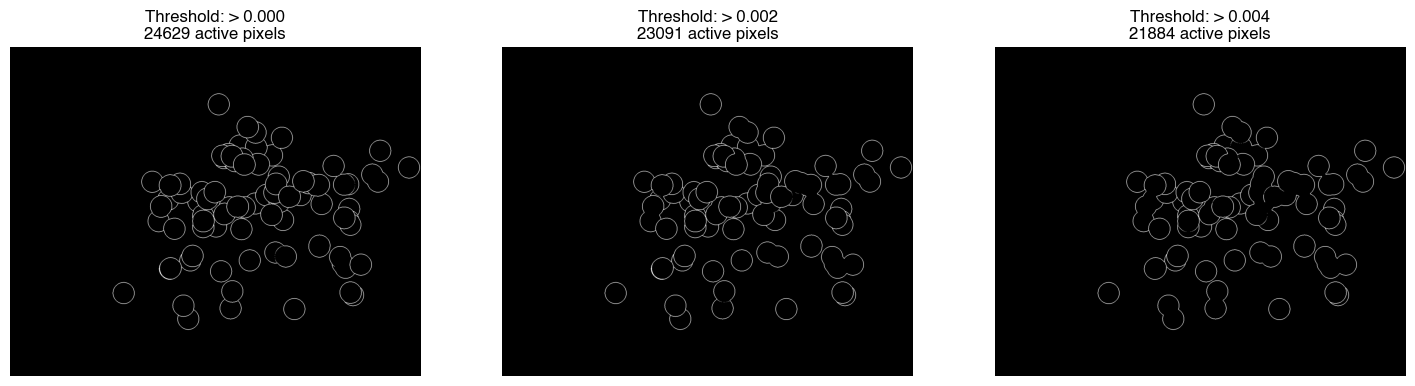

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = [
    np.nanmean(grad_mag),
    np.nanmean(grad_mag) + 0.5*np.nanstd(grad_mag),
    np.nanmean(grad_mag) + np.nanstd(grad_mag),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, th in zip(axes, thresholds):
    mask = (grad_mag > th)
    ax.imshow(mask, cmap='gray', origin='upper')
    ax.set_title(f"Threshold: > {th:.3f}\n{mask.sum()} active pixels")
    ax.axis('off')

plt.show()


#

#

#

In [49]:
gy, gx = np.gradient(smooth_potential_raster, edge_order=2)

In [50]:
grad_y, grad_x = np.gradient(smooth_potential_raster, resolution, resolution)

grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
grad_direction = np.arctan2(grad_y, grad_x)

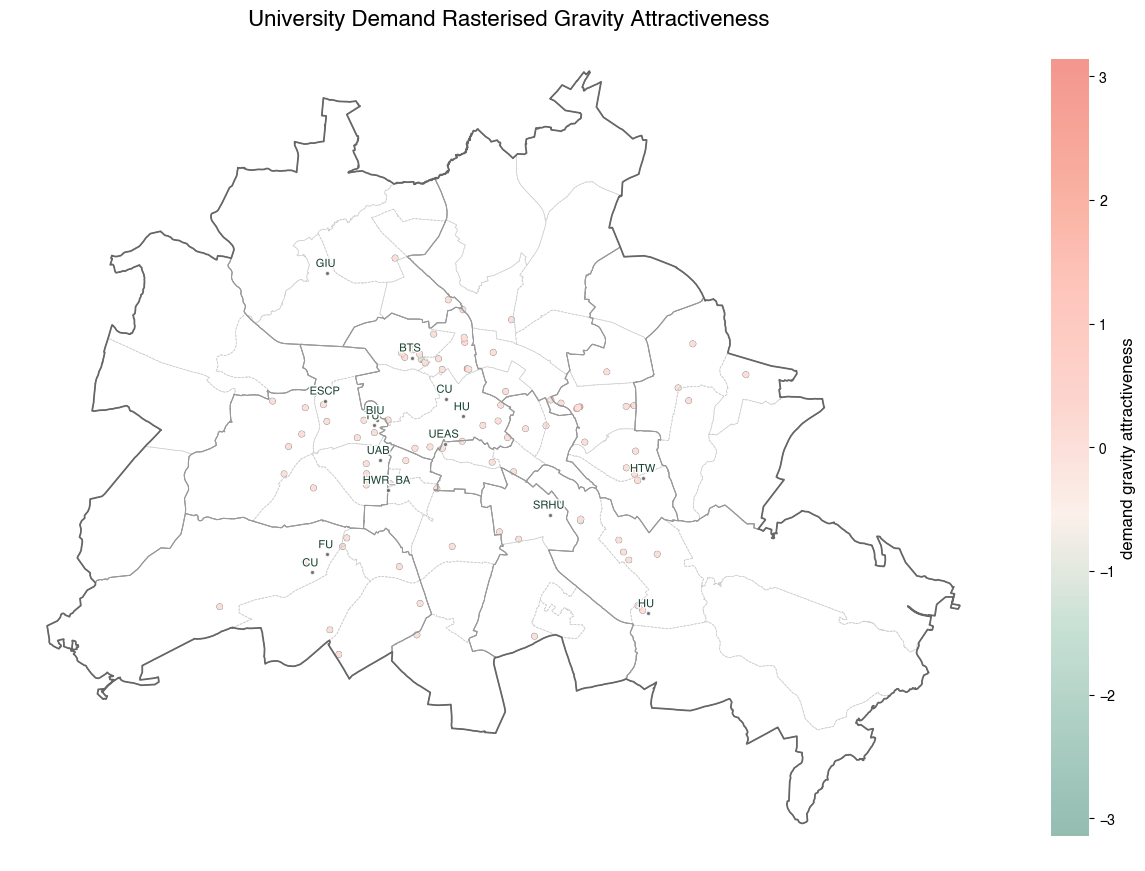

In [51]:
cmap_mintpi_mini = ListedColormap(cmap_mintpi(np.linspace(0.15, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

cax = ax.imshow(grad_direction, cmap=cmap_mintpi_mini,
                    extent=(minx, maxx, miny, maxy))


cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('demand gravity attractiveness', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

ax.set_title('University Demand Rasterised Gravity Attractiveness', fontsize=16, weight='bold')
ax.set_axis_off()
plt.show()

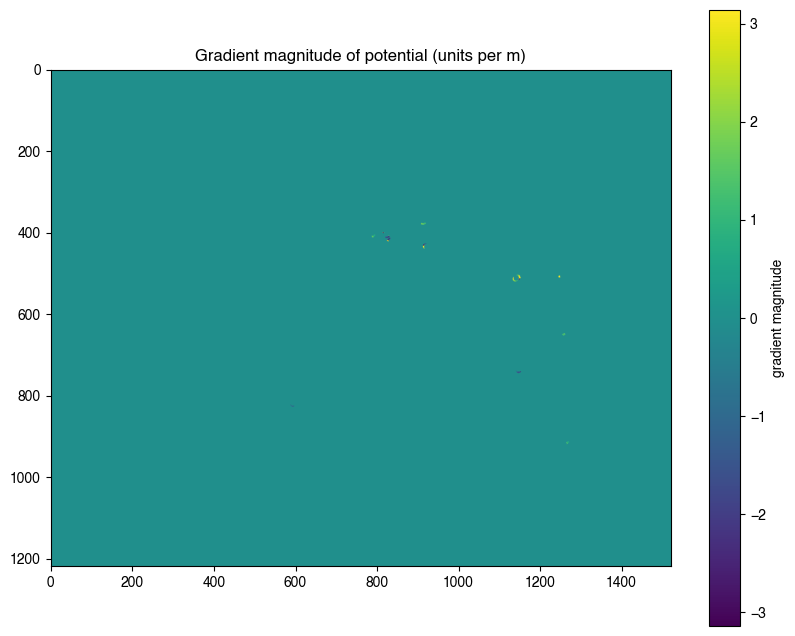

In [52]:
plt.figure(figsize=(10,8))
plt.imshow(grad_mag, origin='upper')
plt.imshow(grad_dir, origin='upper')
plt.title('Gradient magnitude of potential (units per m)')
plt.colorbar(label='gradient magnitude')
plt.show()

# Archive

In [25]:
grad_y, grad_x = np.gradient(smooth_potential_raster, resolution, resolution)

grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

In [99]:


# ------------------------------------------------------------------
# 1️⃣  Assume the following variables already exist in the session:
#     - pbsa_cap, central_places, market_area (your GeoDataFrames)
#     - potential_raster  (2‑D float array, the raw raster you just created)
#     - grad_x, grad_y, grad_magnitude   (numpy arrays, same shape as raster)
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 2️⃣  Basemap layers (replace if you use other layers)
# ------------------------------------------------------------------
# pgr, bz, out  are the 3 base layers you had previously
# If you don't have them, just skip their plotting lines
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc',
         linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999',
        linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666',
         linewidth=1.25)

# ------------------------------------------------------------------
# 3️⃣  Gradient‑magnitude raster – choose a nice colormap
# ------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 12))

cax = ax.imshow(grad_magnitude, cmap=cmap_mintor
                extent=(minx, maxx, miny, maxy))

cbar = plt.colorbar(cax, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Gradient magnitude', fontsize=12)   # tweak as needed
cbar.outline.set_visible(False)

# ------------------------------------------------------------------
# 4️⃣  Overlay the quiver (arrows) – show every 20th pixel for legibility
# ------------------------------------------------------------------
step = 20                    # adjust if you want denser or thinner arrows
Y, X = np.meshgrid(np.linspace(miny, maxy, grad_magnitude.shape[0]),
                   np.linspace(minx, maxx, grad_magnitude.shape[1]), indexing="ij")

ax.quiver(X[::step, ::step],           # X‑coordinates of arrow start
          Y[::step, ::step],           # Y‑coordinates of arrow start
          grad_x[::step, ::step],      # X‑component of gradient
          grad_y[::step, ::step],      # Y‑component of gradient
          scale=5e6,                    # adjust for correct arrow length
          width=0.002,                   # arrow thickness
          color="#000000",               # black arrows
          zorder=5)

# ------------------------------------------------------------------
# 5️⃣  Plot central places with labels (reuse your block)
# ------------------------------------------------------------------
central_places.plot(ax=ax, color='#434343', markersize=10,
                    alpha=0.75, edgecolor='white', linewidth=1)

for idx, row in central_places.iterrows():
    ax.annotate(row['abr'],
                xy=(row.geometry.x, row.geometry.y),
                xytext=(0, 3),  # 3 points upward
                textcoords='offset points',
                color='#1b4332',
                fontsize=8,
                ha='center',
                va='bottom',
                alpha=1,
                zorder=6,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='white'),
                              path_effects.Normal()])

# ------------------------------------------------------------------
# 6️⃣  Final touches
# ------------------------------------------------------------------
ax.set_title('Gradient magnitude & vector field of PBSA potential',
             fontsize=16, weight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3056070910.py, line 26)

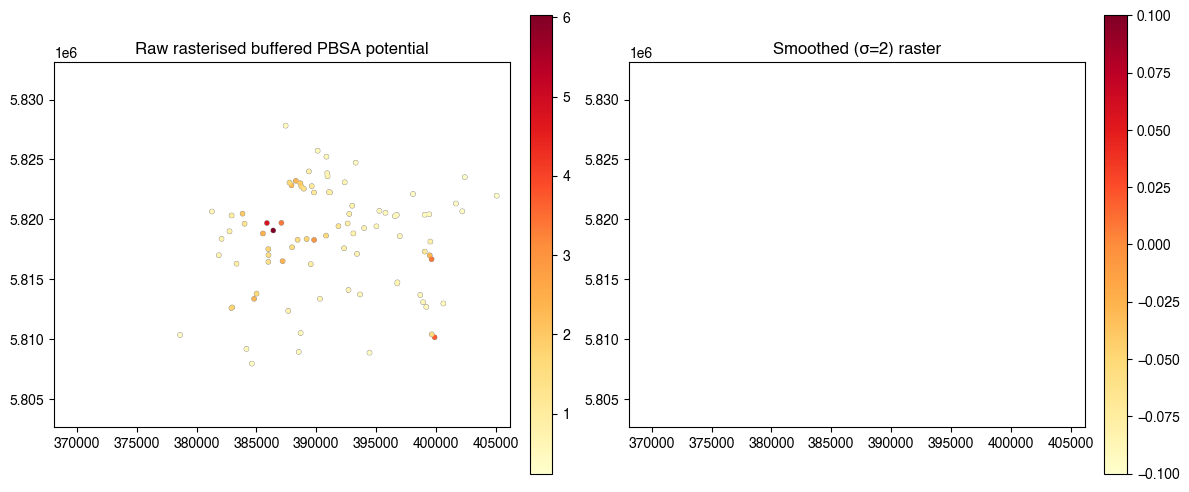

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,6))

cax0 = ax[0].imshow(potential_raster, cmap="YlOrRd",
                    extent=(minx, maxx, miny, maxy))
ax[0].set_title("Raw rasterised buffered PBSA potential")
fig.colorbar(cax0, ax=ax[0], fraction=0.046, pad=0.04)

cax1 = ax[1].imshow(smooth_raster, cmap="YlOrRd",
                    extent=(minx, maxx, miny, maxy))
ax[1].set_title("Smoothed (σ=2) raster")
fig.colorbar(cax1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
plt.show()

In [ ]:
# ------------------------------------------------------------------
# 0️⃣  Imports – everything you need
# ------------------------------------------------------------------
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features      # <‑‑ THIS line is crucial
from affine import Affine
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist

# ------------------------------------------------------------------
# 1️⃣  Load / already loaded layers
# ------------------------------------------------------------------
# pbsa_cap, central_places, market_area should already exist in the
# current session. If not, uncomment the lines below and point to your
# files (.gpkg).
#
# pbsa_cap      = gpd.read_file("../inputs/.../pbsa_capacity_analysis.gpkg")
# central_places = gpd.read_file("../inputs/.../central_places.gpkg")
# market_area      = gpd.read_file("../inputs/.../market_area_central_place_analysis_35_min.gpkg")

# ------------------------------------------------------------------
# 2️⃣  Compute the gravity potential (β = 1.25)
# ------------------------------------------------------------------
# 2.1  Centroid coordinates – PBSA ↔ central places
x_orig = pbsa_cap.geometry.centroid.x.values
y_orig = pbsa_cap.geometry.centroid.y.values
orig_grid = np.column_stack([x_orig, y_orig])           # (N, 2)

x_dest = central_places.geometry.centroid.x.values
y_dest = central_places.geometry.centroid.y.values
dest_grid = np.column_stack([x_dest, y_dest])          # (M, 2)

# 2.2  Distance matrix (N × M)
dist_mat = cdist(orig_grid, dest_grid)

# 2.3  Apply the gravity formula
beta = 1.25
attract = central_places["!s_aus"].values            # (M,)

# avoid division‑by‑zero
eps = 1e-6
dist_cache = np.where(dist_mat == 0, eps, dist_mat)

weights   = attract / (dist_cache ** beta)           # (N, M)
potential = weights.sum(axis=1)                      # (N,)

# 2.4  Store the potential back in the GeoDataFrame
pbsa_cap["!cap"] = potential

# ------------------------------------------------------------------
# 3️⃣  Rasterise the potential field
# ------------------------------------------------------------------
# Parameters you already chose
resolution = 25          # metres per pixel
sigma      = 2           # Gaussian‑smoothing width

# 3.1  Raster extent – use the market_area bounding box
minx, miny, maxx, maxy = market_area.total_bounds
transform = Affine.translation(minx, maxy) * Affine.scale(resolution, -resolution)

width  = int(np.ceil((maxx - minx) / resolution))
height = int(np.ceil((maxy - miny) / resolution))

# 3.2  Rasterise PBSA points with their !cap values
shapes_vals = zip(pbsa_cap.geometry, pbsa_cap["!cap"])
potential_raster = features.rasterize(
    shapes_vals,
    out_shape=(height, width),
    fill=np.nan,                           # NaNs where no PBSA falls
    transform=transform,
    dtype=np.float32,
    all_touched=False                      # only the pixel that contains the point
)

# ------------------------------------------------------------------
# 4️⃣  Gaussian smoothing
# ------------------------------------------------------------------
smooth_raster = gaussian_filter(potential_raster, sigma=sigma, mode='nearest')

# ------------------------------------------------------------------
# 5️⃣  Write the rasters to GeoTIFF
# ------------------------------------------------------------------
out_raw   = r"../outputs/4.3_modeling_approach/potential_raw.tif"
out_smooth = r"../outputs/4.3_modeling_approach/potential_smooth.tif"

profile = {
    "driver": "GTiff",
    "height": height,
    "width":  width,
    "count": 1,
    "dtype": rasterio.float32,
    "crs": pbsa_cap.crs.to_string(),
    "transform": transform,
    "nodata": np.nan,
    "compress": "lzw",
}

with rasterio.open(out_raw, "w", **profile) as dst:
    dst.write(potential_raster, 1)

with rasterio.open(out_smooth, "w", **profile) as dst:
    dst.write(smooth_raster, 1)

print("Successfully written:")
print(f"  Raw raster  : {out_raw}")
print(f"  Smooth raster: {out_smooth}")

Successfully written:
  Raw raster  : ../outputs/4.3_modeling_approach/potential_raw.tif
  Smooth raster: ../outputs/4.3_modeling_approach/potential_smooth.tif


# aRCHIVE

In [ ]:
# #Raster bounds
# minx, miny, maxx, maxy = market_area.total_bounds        # (xmin, ymin, xmax, ymax)

# #Add a small buffer so edges are not cut off
# buffer_m = 500                                       # 500 m buffer in metres
# minx -= buffer_m; miny -= buffer_m; maxx += buffer_m; maxy += buffer_m

# #Raster resolution – choose a cell size 
# cell_size = 25                                      # metres per pixel

# # Calculate number of columns and rows
# cols = int(np.ceil((maxx - minx) / cell_size))
# rows = int(np.ceil((maxy - miny) / cell_size))

# #Affine transform: defines where pixel (0,0) sits
# from rasterio.transform import from_origin
# transform = from_origin(minx, maxy, cell_size, cell_size) 

In [ ]:
# Determine bounds that cover all PBSA points + a small buffer
minx, miny, maxx, maxy = market_area.total_bounds
# Add a buffer on every side to make sure the raster touches the edges
buffer = 500
minx -= buffer; miny -= buffer; maxx += buffer; maxy += buffer

# Define raster resolution
dx = dy = 25
cols = int(np.ceil((maxx - minx) / dx))
rows = int(np.ceil((maxy - miny) / dy))

# Affine transform (top‑left origin)
transform = from_origin(minx, maxy, dx, dy)

# Rasterise PBSA potential values: for every cell we compute the *maximum*
# potential of all points that fall inside that cell (steps of 1 m are too fine).
# Rasterio's features.rasterize will do that for us.
raster_vals = np.full((rows, cols), np.nan, dtype=np.float32)

shapes_and_vals = zip(pbsa_cap.geometry, pbsa_cap["!cap"])
burned = rasterio.features.rasterize(
    shapes_and_vals,
    out_shape=(rows, cols),
    fill=np.nan,
    transform=transform,
    dtype=np.float32,
    all_touched=False,
    default_value=np.nan
)

transform = from_origin(minx, maxy, cell_size, cell_size) 

Gradient of Gravity Potential

In [13]:
grad_y, grad_x = np.gradient(burned, dy, dx)   # grads in potential per metre

# Magnitude of gradient (how fast the potential changes)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

Data Visualisation 

*build pbsa Potential Map   
potential field raster  
gradient of potential field*

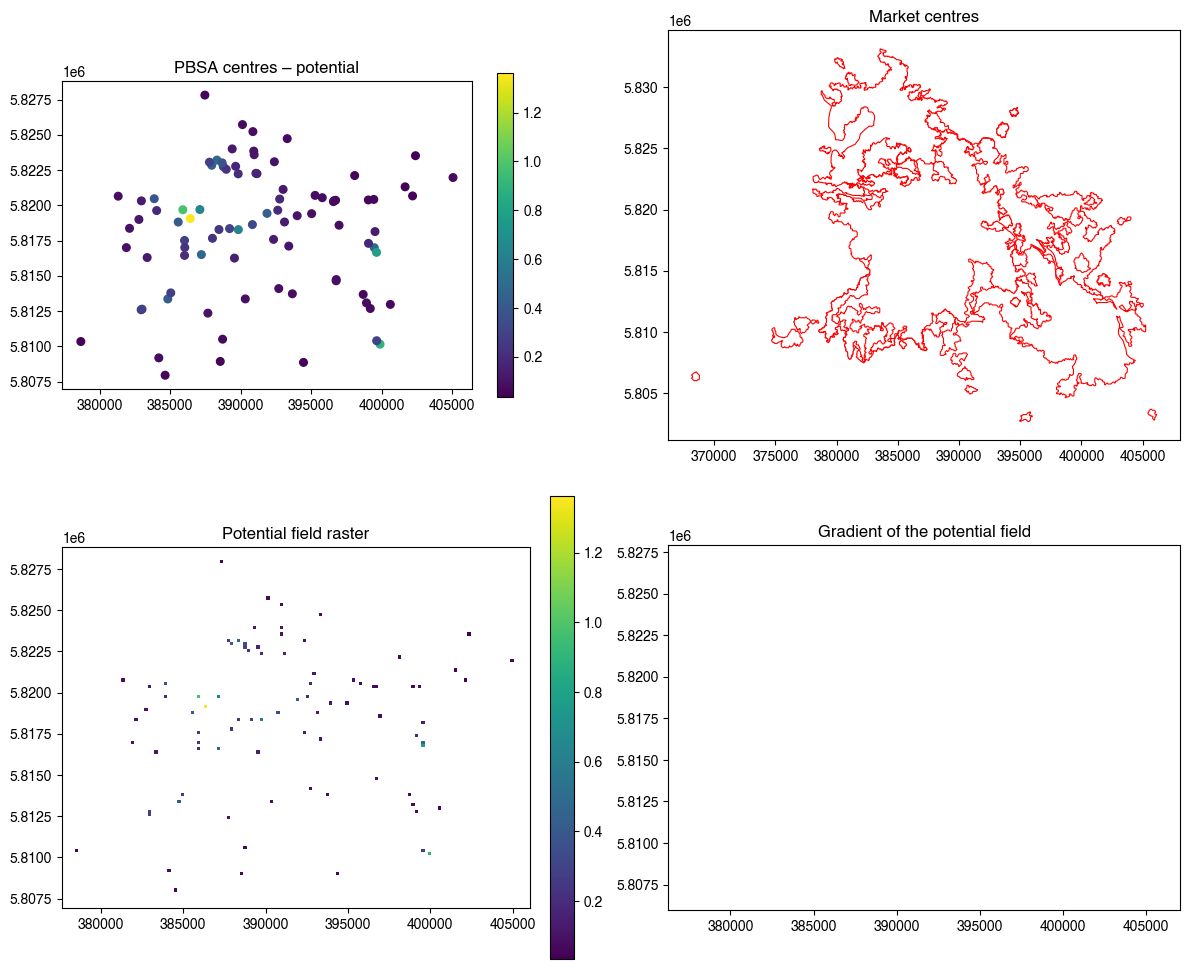

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# a) PBSA point layer coloured by potential
pbsa_cap.plot(column="!cap", cmap="viridis", ax=ax[0,0], markersize=30,
              legend=True, legend_kwds={"shrink":0.7})
ax[0,0].set_title("PBSA centres – potential")

# b) Market centres
market_area.plot(ax=ax[0,1], color="white", edgecolor="red", linewidth=0.8,
                 markersize=20)
ax[0,1].set_title("Market centres")

# c) Raster of potential
cax = ax[1,0].imshow(burned, cmap="viridis", extent=(minx, maxx, miny, maxy))
ax[1,0].set_title("Potential field raster")
fig.colorbar(cax, ax=ax[1,0], fraction=0.046, pad=0.04)

# d) Gradient vectors over the raster grid
# Show only a subset for clarity: every 10‑th cell
step = 10
Y, X = np.meshgrid(np.arange(miny, maxy, dy),
                   np.arange(minx, maxx, dx), indexing="ij")
ax[1,1].quiver(X[::step, ::step], Y[::step, ::step],
                grad_x[::step, ::step], grad_y[::step, ::step],
                scale=5e6, color="black")
ax[1,1].set_title("Gradient of the potential field")
ax[1,1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Gravity Potential Model

## The Gradient of Gravity Potential

# Archive 

## Huff Modeling

In [ ]:
# import geopandas as gpd
# import huff
# #from huff import Origin, Destination, HuffModel, DistanceMatrix

# # 1. Load your data
# origins = uni_dem     # e.g., student demand points or zones
# destin = pbsa_cap # e.g., PBSA supply locations

# # 2. Create Origin and Destination objects
# orig = Origin.from_geodataframe(origins, weight_col='!s_aus')   # weight = international student demand
# dest = Destination.from_geodataframe(destin, weight_col='!cap') # weight = capacity

# # 3. Compute distances or travel-costs (euclidean or via network)
# dm = DistanceMatrix.compute(orig, dest, metric='euclidean')  # simple version

# # 4. Instantiate Huff Model
# model = HuffModel(orig, dest, distance_matrix=dm,
#                   decay_function='power', beta=2.0)  # β = 2 for example

# # 5. Run probabilities
# probabilities = model.run()

# # 6. Assign each origin a destination with highest probability (or compute expected flows)
# flows = model.expected_flows()

# # 7. Summarise results: e.g., which PBSA draws most demand, which areas are underserved
# summary = model.summary()

# # print(summary)


NameError: name 'uni_dem' is not defined

## Patronage Analysis

## Gravity Modeling 

Origins / Destinations

In [ ]:
x_orig = pbsa_cap.geometry.centroid.x.values
y_orig = pbsa_cap.geometry.centroid.y.values
orig_grid = np.column_stack([x_orig, y_orig])   # shape (N,2)

# Market centres → destinations (column axis)
x_dest = market_area.geometry.centroid.x.values
y_dest = market_area.geometry.centroid.y.values
dest_grid = np.column_stack([x_dest, y_dest]) 

In [ ]:
# Origin table – take the centroid of each university (already a point geometry)
orig = central_places[["code","name","lat","lon","!s_aus","!s_aus_slag","geometry"]].copy()
orig = orig.rename(columns={"!s_aus":"P_o"})         # demand
orig["id_o"] = orig.index                          # int ID
orig = orig.set_index("id_o")

# Destination table – PBSA centroids
dest = pbsa_cap[["name","city","plz","!cap","!cap_std","!cap_slag","!cap_slag_std","geometry"]].copy()
dest = dest.rename(columns={"!cap":"P_d"})           # capacity
dest["id_d"] = dest.index
dest = dest.set_index("id_d")   

In [ ]:
print(orig["P_o"].head())
print(central_places["!s_aus"].head())

print("sum !s_aus :", central_places["!s_aus"].sum())
print("sum P_o     :", orig["P_o"].sum())

Distance Matrix

In [ ]:
orig_xy = orig.geometry.apply(lambda g: (g.x, g.y)).tolist()
dest_xy = dest.geometry.apply(lambda g: (g.x, g.y)).tolist()

distmat = distance_matrix(orig_xy, dest_xy)    

distmat

Raw Gravity Weights (!!!!! Test is Needed!!!!!)

In [ ]:
# β – initial guess
beta = 1.5

# outer product (P_o * P_d) gives a 15x88 matrix of potentials
pot = np.multiply.outer(orig["P_o"].values, dest["P_d"].values)

# avoid division by zero (in case any d==0) – add a tiny epsilon
eps = 1e-6
W_raw = pot / ((distmat + eps) ** beta)    # shape (15, 88)

Normalisation

In [ ]:
W_norm = W_raw / np.sum(W_raw, axis=0, keepdims=True)  # divide along origins

In [ ]:
W_df = pd.DataFrame(W_norm)

# Reset index and melt
W_df = (
    W_df.reset_index()                    # Adds 'index' column (original row IDs)
    .melt(
        id_vars='index',                 # Keep 'index' column as identifier
        var_name='id_d',                 # Rename columns to 'id_d' (destination)
        value_name='share'               # Rename values to 'share'
    )
    .rename(columns={'index': 'id_o'})   # Rename 'index' → 'id_o' (origin)
)

In [ ]:
pbsa_in_area = gpd.sjoin(pbsa_cap[['geometry']],          # only geometry needed
                          market_area[['iso_id', 'geometry']],
                          predicate='within',
                          how='inner')                                                           
# ---- b) create a mapping table id_d -> iso_id
# pbsa_cap index is id_d; we keep it as the index
iso_mapping = pbsa_in_area[['iso_id']].copy()
iso_mapping.index = pbsa_in_area.index

# ---- c) merge the mapping into W_df
W_df = W_df.merge(iso_mapping, left_on='id_d', right_index=True, how='left')

In [ ]:
W_df['cap_share'] = W_df['share'] * dest.loc[W_df['id_d'], 'P_d'].values

# aggregate to market‑area
alloc = (W_df
         .groupby('iso_id')['cap_share']
         .sum()
         .reset_index()
         .rename(columns={'cap_share':'W_agg'}))

In [ ]:
market_area = market_area.merge(alloc, left_index=True, right_on='iso_id', how='left')
market_area['W_agg'] = market_area['W_agg'].fillna(0.0)   # just in case

In [ ]:
print(market_area[['iso_id', 'W_agg']].head())
print("\nValues that are >0:")
print(market_area[market_area['W_agg']>0][['iso_id','W_agg']].head())

In [ ]:
ef = r"/Users/natashlaz/Downloads/output/market_area_gravity_i.gpkg"
market_area.to_file(ef, driver="GPKG")

=== Fixed Central Place Theory and Gravity Model Analysis ===

1. DATA PREPARATION
Checking PBSA capacity data...
pbsa_cap type: <class 'geopandas.geodataframe.GeoDataFrame'>
pbsa_cap shape: (88, 20)
pbsa_cap columns: ['name', 'plz', 'city', 'model', 'ownership', 'ownership_model', '!cap', 'units type', 'price_min', 'price_max', 'area_min', 'area_max', 'link', '!cap_slag', '!cap_std', '!cap_slag_std', 'color', 'cluster', 'cluster_cap', 'geometry']

Checking university demand data...
uni_dem type: <class 'geopandas.geodataframe.GeoDataFrame'>
uni_dem shape: (71, 20)
uni_dem columns: ['code', 'abr', 'name', 'fname', 'adr', 'own', 'stud', '!s_de', '!s_aus', '!s_all', 'url', 'lat', 'lon', 'cluster', '!s_aus_std', '!s_aus_slag', '!s_aus_slag_std', 'color', 'cluster_aus', 'geometry']

2. CENTRAL PLACE ANALYSIS

3. GRAVITY MODEL ANALYSIS

4. MISMATCH ANALYSIS
Running analysis...
✓ Central Place analysis complete: 88 PBSAs
⚠ 'capacity' column not found in pbsa_gdf, using default value 100
⚠ 'd

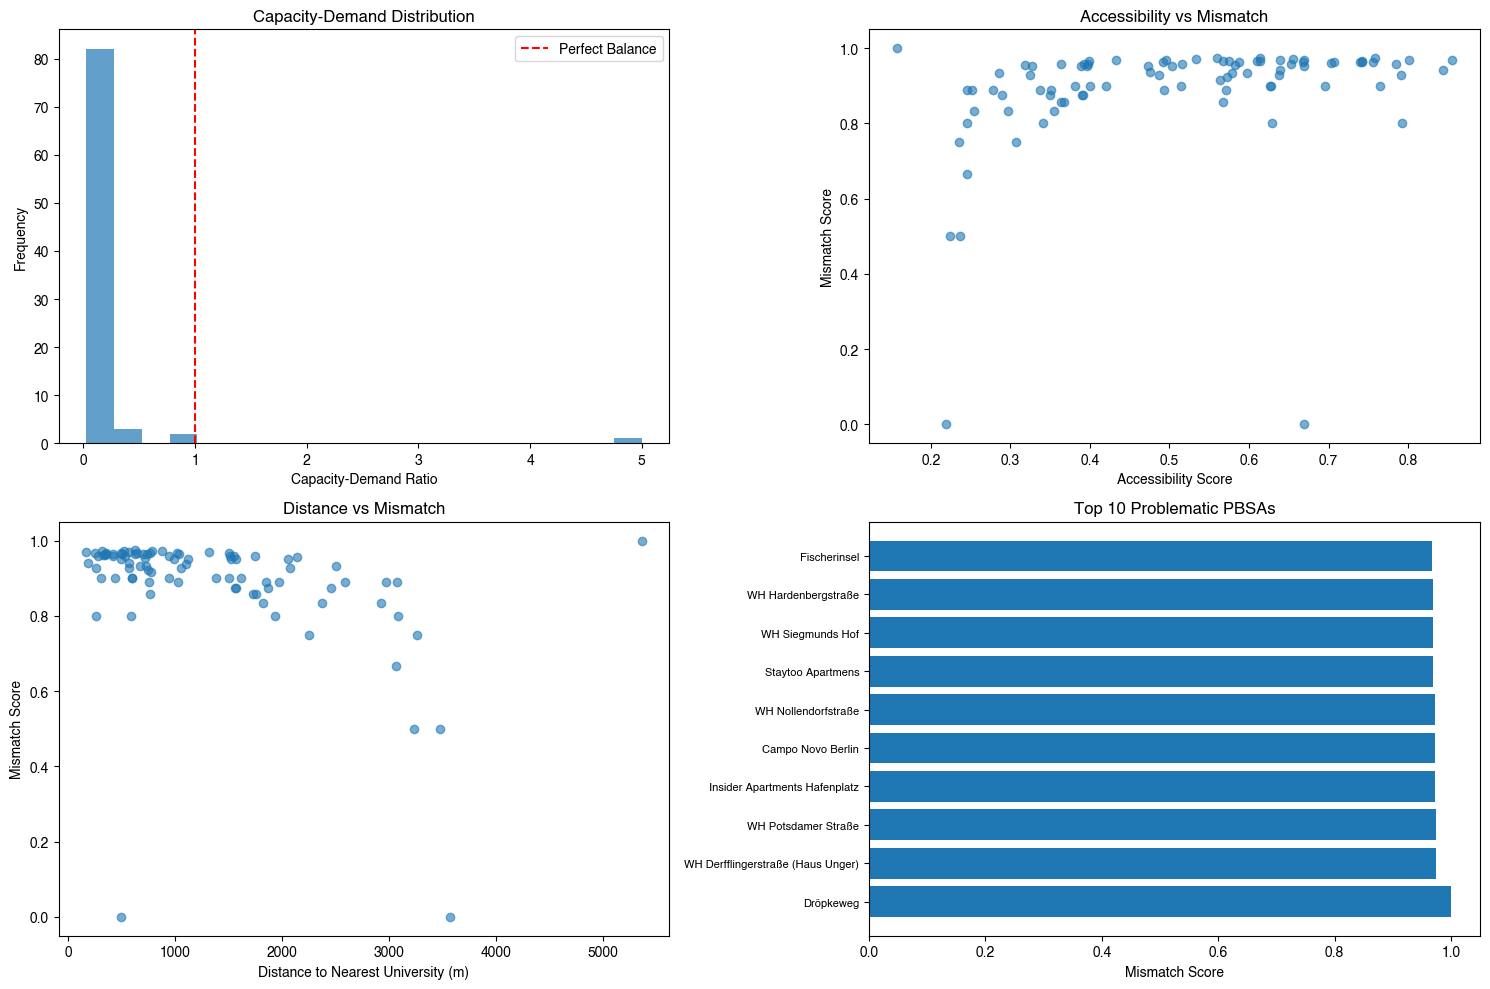


6. POLICY RECOMMENDATIONS

🔴 UNDERSERVED AREAS (83 PBSAs):
  Recommended: Increase PBSA capacity
    • 
StudentHouse Plänterwald in der Eichbuschallee: Capacity/Demand = 0.12
    • "Leuchtturm": Capacity/Demand = 0.20
    • Am Mühlenberg: Capacity/Demand = 0.04
    • Bergaustraße Treptow-Köpenick: Capacity/Demand = 0.12
    • Brückenstraße Treptow-Köpenick: Capacity/Demand = 0.11

🟢 OVERSERVED AREAS (1 PBSAs):
  Recommended: Consider demand management
    • Dröpkeweg: Capacity/Demand = inf

⚠ HIGH PRIORITY AREAS (4 PBSAs):
  High mismatch + low accessibility
    • Dröpkeweg: Mismatch=1.000, Accessibility=0.157
    • Staytoo Apartmens: Mismatch=0.970, Accessibility=0.432
    • Studio BII: Mismatch=0.968, Accessibility=0.496
    • WH Franz-Mehring-Platz: Mismatch=0.967, Accessibility=0.399

=== Analysis Complete ===


In [ ]:
# VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING

# Fixed Gravity Model Analysis
# Copy this into your Jupyter notebook

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Fixed Central Place Theory and Gravity Model Analysis ===")

# 1. DATA PREPARATION
print("\n1. DATA PREPARATION")

# Check your data structure first
print("Checking PBSA capacity data...")
print(f"pbsa_cap type: {type(pbsa_cap)}")
print(f"pbsa_cap shape: {pbsa_cap.shape}")
print(f"pbsa_cap columns: {list(pbsa_cap.columns)}")

print("\nChecking university demand data...")
print(f"uni_dem type: {type(uni_dem)}")
print(f"uni_dem shape: {uni_dem.shape}")
print(f"uni_dem columns: {list(uni_dem.columns)}")

# Ensure both datasets are GeoDataFrames
if not isinstance(pbsa_cap, gpd.GeoDataFrame):
    # Convert to GeoDataFrame
    geom_col = None
    for col in ['geometry', 'geom', 'shape']:
        if col in pbsa_cap.columns:
            geom_col = col
            break
    
    if geom_col:
        pbsa_cap_gdf = gpd.GeoDataFrame(pbsa_cap, geometry=geom_col)
        print(f"✓ Converted pbsa_cap to GeoDataFrame using {geom_col}")
    else:
        print("⚠ No geometry column found in pbsa_cap")
        pbsa_cap_gdf = None
else:
    pbsa_cap_gdf = pbsa_cap

if not isinstance(uni_dem, gpd.GeoDataFrame):
    # Convert to GeoDataFrame
    geom_col = None
    for col in ['geometry', 'geom', 'shape']:
        if col in uni_dem.columns:
            geom_col = col
            break
    
    if geom_col:
        uni_dem_gdf = gpd.GeoDataFrame(uni_dem, geometry=geom_col)
        print(f"✓ Converted uni_dem to GeoDataFrame using {geom_col}")
    else:
        print("⚠ No geometry column found in uni_dem")
        uni_dem_gdf = None
else:
    uni_dem_gdf = uni_dem

# 2. CENTRAL PLACE ANALYSIS
print("\n2. CENTRAL PLACE ANALYSIS")

def analyze_central_place(pbsa_gdf, uni_gdf):
    """Analyze spatial relationships using Central Place Theory"""
    
    # Calculate centroids
    pbsa_centroids = pbsa_gdf.geometry.centroid
    uni_centroids = uni_gdf.geometry.centroid
    
    # Calculate distances
    distances = cdist(
        np.array([[p.x, p.y] for p in pbsa_centroids]),
        np.array([[u.x, u.y] for u in uni_centroids])
    )
    
    # Find nearest university for each PBSA
    nearest_uni_indices = np.argmin(distances, axis=1)
    nearest_distances = np.min(distances, axis=1)
    
    # Calculate market areas (5km radius)
    market_areas = []
    for i in range(len(pbsa_gdf)):
        nearby_unis = distances[i] < 5000  # 5km threshold
        total_demand = sum([uni_gdf.iloc[j].get('demand', 100) 
                           for j in range(len(uni_gdf)) if nearby_unis[j]])
        
        market_areas.append({
            'pbsa_id': i,
            'pbsa_name': pbsa_gdf.iloc[i].get('name', f'PBSA_{i}'),
            'capacity': pbsa_gdf.iloc[i].get('capacity', 100),
            'nearest_uni': uni_gdf.iloc[nearest_uni_indices[i]].get('name', 'Unknown'),
            'nearest_distance': nearest_distances[i],
            'nearby_unis_count': np.sum(nearby_unis),
            'total_demand_in_range': total_demand
        })
    
    return pd.DataFrame(market_areas)

# 3. GRAVITY MODEL ANALYSIS (FIXED)
print("\n3. GRAVITY MODEL ANALYSIS")

def analyze_gravity_model(pbsa_gdf, uni_gdf, beta=2.0):
    """Analyze interactions using Gravity Model"""
    
    # Calculate centroids and distances
    pbsa_centroids = pbsa_gdf.geometry.centroid
    uni_centroids = uni_gdf.geometry.centroid
    
    distances = cdist(
        np.array([[p.x, p.y] for p in pbsa_centroids]),
        np.array([[u.x, u.y] for u in uni_centroids])
    )
    
    # Get capacities and demands - FIXED VERSION
    # Check if columns exist, otherwise use default values
    if 'capacity' in pbsa_gdf.columns:
        pbsa_capacities = pbsa_gdf['capacity'].values
    else:
        pbsa_capacities = np.array([100] * len(pbsa_gdf))
        print("⚠ 'capacity' column not found in pbsa_gdf, using default value 100")
    
    if 'demand' in uni_gdf.columns:
        uni_demands = uni_gdf['demand'].values
    else:
        uni_demands = np.array([100] * len(uni_gdf))
        print("⚠ 'demand' column not found in uni_gdf, using default value 100")
    
    # Calculate gravity interactions
    gravity_results = []
    for i in range(len(pbsa_gdf)):
        pbsa_capacity = pbsa_capacities[i]
        total_interaction = 0
        
        for j in range(len(uni_gdf)):
            uni_demand = uni_demands[j]
            distance = distances[i, j]
            
            if distance > 0:
                interaction = (pbsa_capacity * uni_demand) / (distance ** beta)
                total_interaction += interaction
        
        gravity_results.append({
            'pbsa_id': i,
            'pbsa_name': pbsa_gdf.iloc[i].get('name', f'PBSA_{i}'),
            'total_gravity_interaction': total_interaction
        })
    
    return pd.DataFrame(gravity_results)

# 4. MISMATCH ANALYSIS
print("\n4. MISMATCH ANALYSIS")

def calculate_mismatch(central_place_df, gravity_df):
    """Calculate mismatch indicators"""
    
    mismatch_results = []
    
    for i in range(len(central_place_df)):
        cp_row = central_place_df.iloc[i]
        grav_row = gravity_df.iloc[i]
        
        capacity = cp_row['capacity']
        demand = cp_row['total_demand_in_range']
        
        # Calculate mismatch indicators
        capacity_demand_ratio = capacity / demand if demand > 0 else float('inf')
        mismatch_score = abs(1 - capacity_demand_ratio) if capacity_demand_ratio != float('inf') else 1
        accessibility_score = 1 / (1 + cp_row['nearest_distance']/1000)
        
        mismatch_results.append({
            'pbsa_name': cp_row['pbsa_name'],
            'capacity': capacity,
            'demand': demand,
            'capacity_demand_ratio': capacity_demand_ratio,
            'mismatch_score': mismatch_score,
            'accessibility_score': accessibility_score,
            'nearest_distance': cp_row['nearest_distance'],
            'gravity_interaction': grav_row['total_gravity_interaction']
        })
    
    return pd.DataFrame(mismatch_results)

# Run the analysis
if pbsa_cap_gdf is not None and uni_dem_gdf is not None:
    print("Running analysis...")
    
    # Central Place Analysis
    central_place_df = analyze_central_place(pbsa_cap_gdf, uni_dem_gdf)
    print(f"✓ Central Place analysis complete: {len(central_place_df)} PBSAs")
    
    # Gravity Model Analysis
    gravity_df = analyze_gravity_model(pbsa_cap_gdf, uni_dem_gdf)
    print(f"✓ Gravity model analysis complete: {len(gravity_df)} PBSAs")
    
    # Mismatch Analysis
    mismatch_df = calculate_mismatch(central_place_df, gravity_df)
    print(f"✓ Mismatch analysis complete: {len(mismatch_df)} PBSAs")
    
    # 5. RESULTS AND VISUALIZATION
    print("\n5. RESULTS AND VISUALIZATION")
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"  - Average capacity-demand ratio: {mismatch_df['capacity_demand_ratio'].mean():.2f}")
    print(f"  - Average mismatch score: {mismatch_df['mismatch_score'].mean():.3f}")
    print(f"  - Average accessibility score: {mismatch_df['accessibility_score'].mean():.3f}")
    
    # Identify problem areas
    underserved = mismatch_df[mismatch_df['capacity_demand_ratio'] < 0.5]
    overserved = mismatch_df[mismatch_df['capacity_demand_ratio'] > 2.0]
    
    print(f"\nProblem Areas:")
    print(f"  - Underserved (capacity < 50% demand): {len(underserved)} PBSAs")
    print(f"  - Overserved (capacity > 200% demand): {len(overserved)} PBSAs")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Capacity-Demand Ratio Distribution
    axes[0, 0].hist(mismatch_df['capacity_demand_ratio'].clip(0, 5), bins=20, alpha=0.7)
    axes[0, 0].axvline(1, color='red', linestyle='--', label='Perfect Balance')
    axes[0, 0].set_xlabel('Capacity-Demand Ratio')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Capacity-Demand Distribution')
    axes[0, 0].legend()
    
    # 2. Accessibility vs Mismatch
    axes[0, 1].scatter(mismatch_df['accessibility_score'], mismatch_df['mismatch_score'], alpha=0.6)
    axes[0, 1].set_xlabel('Accessibility Score')
    axes[0, 1].set_ylabel('Mismatch Score')
    axes[0, 1].set_title('Accessibility vs Mismatch')
    
    # 3. Distance vs Mismatch
    axes[1, 0].scatter(mismatch_df['nearest_distance'], mismatch_df['mismatch_score'], alpha=0.6)
    axes[1, 0].set_xlabel('Distance to Nearest University (m)')
    axes[1, 0].set_ylabel('Mismatch Score')
    axes[1, 0].set_title('Distance vs Mismatch')
    
    # 4. Top 10 problematic PBSAs
    top_problems = mismatch_df.nlargest(10, 'mismatch_score')
    axes[1, 1].barh(range(len(top_problems)), top_problems['mismatch_score'])
    axes[1, 1].set_yticks(range(len(top_problems)))
    axes[1, 1].set_yticklabels(top_problems['pbsa_name'], fontsize=8)
    axes[1, 1].set_xlabel('Mismatch Score')
    axes[1, 1].set_title('Top 10 Problematic PBSAs')
    
    plt.tight_layout()
    plt.show()
    
    # 6. POLICY RECOMMENDATIONS
    print("\n6. POLICY RECOMMENDATIONS")
    
    if len(underserved) > 0:
        print(f"\n🔴 UNDERSERVED AREAS ({len(underserved)} PBSAs):")
        print("  Recommended: Increase PBSA capacity")
        for _, row in underserved.head(5).iterrows():
            print(f"    • {row['pbsa_name']}: Capacity/Demand = {row['capacity_demand_ratio']:.2f}")
    
    if len(overserved) > 0:
        print(f"\n🟢 OVERSERVED AREAS ({len(overserved)} PBSAs):")
        print("  Recommended: Consider demand management")
        for _, row in overserved.head(5).iterrows():
            print(f"    • {row['pbsa_name']}: Capacity/Demand = {row['capacity_demand_ratio']:.2f}")
    
    # High priority areas (high mismatch + low accessibility)
    high_priority = mismatch_df[
        (mismatch_df['mismatch_score'] > mismatch_df['mismatch_score'].quantile(0.8)) &
        (mismatch_df['accessibility_score'] < mismatch_df['accessibility_score'].quantile(0.5))
    ]
    
    if len(high_priority) > 0:
        print(f"\n⚠ HIGH PRIORITY AREAS ({len(high_priority)} PBSAs):")
        print("  High mismatch + low accessibility")
        for _, row in high_priority.head(5).iterrows():
            print(f"    • {row['pbsa_name']}: Mismatch={row['mismatch_score']:.3f}, Accessibility={row['accessibility_score']:.3f}")
    
    print(f"\n=== Analysis Complete ===")
    
else:
    print("⚠ Cannot run analysis - missing GeoDataFrames")

# VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING VIBE CODING
